In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import hdf5plugin 
import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPU


In [2]:
train_img_pt = []
test_img_pt = []
train_label_ = []
test_label_ = []

prefix = "/home/david/ResNet-50-Keras/data/"
train_file = "train/train_file_"
val_file = "val/val_file_"
file_type = ".h5"
path = []
filename = ''
for i in range(5,8):
    seq =  (train_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f:
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(len(pt_)):
            train_img_pt.append(pt_[a])
        for b in range(len(label_)):
            train_label_.append(label_[b])
for i in range(0,1):
    seq =  (val_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,6000):
            test_img_pt.append(pt_[a])
        for b in range(0,6000):
            test_label_.append(label_[b])


In [3]:
def normalize_and_rgb(img, label):  
    output = np.stack([np.asanyarray(img)/ np.asanyarray(img).max(), np.asanyarray(img)/ np.asanyarray(img).max(), np.asanyarray(img)/ np.asanyarray(img).max()],axis=-1)
    return output, np.asanyarray(label)
train_img, train_label = normalize_and_rgb(train_img_pt, train_label_)
test_img, test_label = normalize_and_rgb(test_img_pt, test_label_)

In [4]:
#print(train_img, train_label, test_img, test_label)
#train_label = np.asanyarray(train_label_)
#test_label = np.asanyarray(test_label_)
#print(train_label.shape, test_label.shape)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping,ModelCheckpoint
import keras

model = Sequential()
#model.load_weights=('../aws-fpga-top-tagging-notebooks/dataset_Tom/weights-floatingpoint-224x224-fixval-best/class_weights.h5')
model.add(ResNet50(weights=None, pooling='max'))
model.add(Dense(2, activation='softmax'))


model.summary()
modelcheckpoint = ModelCheckpoint('./model/ResNet-50-best.model',
                                                     monitor='val_acc', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=0, mode='min')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2002      
Total params: 25,638,714
Trainable params: 25,585,594
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
train_history = model.fit(x= train_img, y = train_label, validation_split=0.1, 
                          epochs=10, verbose=1, batch_size=4,
                          callbacks=[roc_callback(training_data=(train_img, train_label),validation_data=(test_img, test_label))] )
#train_history = model.fit_generator(train_dataset.flow(train_img, train_label, batch_size = 16),\
#                                    validation_data=val_dataset.flow(test_img, test_label, batch_size = 16), epochs=10,\
#                                    verbose=1,use_multiprocessing=True, validation_freq=1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/10
27000/27000 [==============================] - 621s 23ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5067
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 2/10
27000/27000 [==============================] - 595s 22ms/step - loss: 0.6934 - accuracy: 0.5032 - val_loss: 0.6935 - val_accuracy: 0.4933
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 3/10
27000/27000 [==============================] - 599s 22ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5067
roc-auc: 0.5 - roc-auc_val: 0.5                                                                                                    
Epoch 4/10
27000/27000 [==============================] - 603s 22ms/step - loss: 0.6935 - accuracy: 0.4993 -

In [ ]:
#Define a function to show training history
def show_train_history(train_history, train, validation,filename):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validaiton'],loc='upper left')
    plt.savefig(filename)
    plt.show()

def plot_images_prediction(iamges, labels, prediction, idx, num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(iamges[idx], cmap='binary')
        title = "label=" + str(np.argmax(labels[idx]))
        if len(prediction)>0 :
            title += ",prediction=" + str(np.argmax(prediction[idx]))
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.savefig(filename)
    plt.show()
    
#Show the result of training 
show_train_history(train_history,'accuracy','val_accuracy','./acc.png')
show_train_history(train_history,'loss','val_loss',filename='./loss.png')


6000/6000 [==============================] - 21s 3ms/step

Accuracy of model is 0.5199999809265137
[[0.5177112  0.48228878]
 [0.5177112  0.48228878]
 [0.5177112  0.48228878]
 ...
 [0.5177112  0.48228878]
 [0.5177112  0.48228878]
 [0.5177112  0.48228878]]


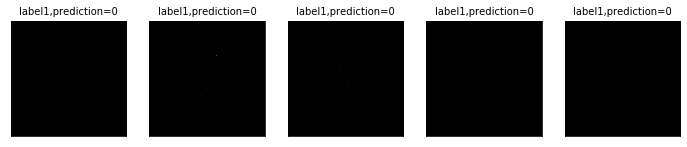

ValueError: If using all scalar values, you must pass an index

In [23]:
#Scoring the accuracy of model by test dataset.
score = model.evaluate(test_img, test_label)
print()
print("Accuracy of model is", score[1])

#Prediction 
prediction = model.predict(test_img)
print(prediction)

test_label_wo_onehot = np.zeros(len(test_label))
pred = np.zeros(len(test_label))
for i in range(len(test_label)):
    test_label_wo_onehot[i] = np.argmax(test_label[i])
    pred[i] = np.argmax(prediction[i])

plot_images_prediction(test_img,test_label, prediction,idx=1,num=5)





In [30]:
#Display confusion matrix
pd.crosstab(test_label_wo_onehot, pred, rownames=['label'], colnames=['predict'])

predict,0.0
label,
0.0,3120
1.0,2880


In [28]:
#Display true value and predict value 
df = pd.DataFrame({'label':test_label_wo_onehot,'predict':pred})
df[:10]



,label,predict
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [29]:
#Find the result that true value is x but pred value is y (x != y)
df[(df.label==0)&(df.predict==1)]


,label,predict
